# Import relevant libraries

In [1]:
import os
import math
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
# disable false positive warnings
pd.options.mode.chained_assignment = None

# Setup path

In [3]:
# set up paths
base_path = '../datasets'
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

# Load data

In [4]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [5]:
perf_eval_df

club_name       player_name   age            position  \
0           Ajax Amsterdam     Marc Overmars  19.0         Left Winger   
1           Ajax Amsterdam     Jari Litmanen  21.0  Attacking Midfield   
2           Ajax Amsterdam       Aron Winter  25.0  Defensive Midfield   
3         Sparta Rotterdam   Winston Bogarde  21.0         Centre-Back   
4        Willem II Tilburg     Marc Overmars  19.0         Left Winger   
...                    ...               ...   ...                 ...   
26883           Sevilla FC   Oussama Idrissi  24.0         Left Winger   
26884           Sevilla FC       Karim Rekik  25.0         Centre-Back   
26885      Athletic Bilbao    Alex Berenguer  25.0         Left Winger   
26886           Granada CF       Luis Suarez  22.0      Centre-Forward   
26887  Real Betis Balompié  Ismael Gutierrez  20.0    Central Midfield   

      club_involved_name transfer_movement  fee_cleaned  year  
0              Willem II                in        0.817  1992  
1                   MYPA                in        0.013  1992  
2                  Lazio               out        1.170  1992  
3              Excelsior                in        0.005  1992  
4                   Ajax               out        0.817  1992  
...                  ...               ...          ...   ...  
26883         AZ Alkmaar                in       10.800  2020  
26884         Hertha BSC                in        1.800  2020  
26885             Torino                in        9.450  2020  
26886            Watford                in        6.300  2020  
26887      Atl. Madrid B               out        0.900  2020  

[26888 rows x 8 columns]

# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe with combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Fee-Age Analysis

In [6]:
fee_age = perf_eval_df[['age', 'fee_cleaned']]
fee_age

age  fee_cleaned
0      19.0        0.817
1      21.0        0.013
2      25.0        1.170
3      21.0        0.005
4      19.0        0.817
...     ...          ...
26883  24.0       10.800
26884  25.0        1.800
26885  25.0        9.450
26886  22.0        6.300
26887  20.0        0.900

[26888 rows x 2 columns]

<AxesSubplot:xlabel='age', ylabel='fee_cleaned'>

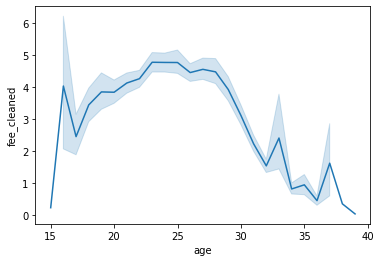

In [7]:
# the variance is quite high
sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.mean, ci = 95)

<AxesSubplot:xlabel='fee_cleaned', ylabel='Count'>

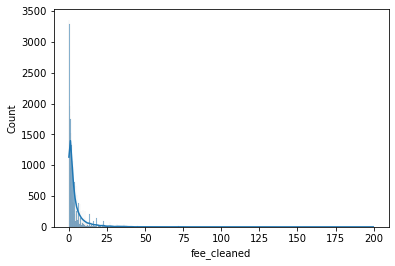

In [8]:
# heavy-tailed distribution --> median would be a more sensible mid-point measure
# as mean would be influenced by the outliers
sns.histplot(fee_age['fee_cleaned'], kde = True)

In [9]:
# descriptive statistics
desc_stat = fee_age.groupby('age')['fee_cleaned']\
                   .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# remove group with small number of observations
desc_stat = desc_stat[desc_stat['count'] > 30]

In [10]:
# There are some outliers that greatly influence the mean and thus using median is more robust
desc_stat

mean  median       std    min     max  count
age                                                   
16.0  4.043097   1.080  6.180176  0.023   18.81     31
17.0  2.461075   0.990  3.822797  0.005   21.60    147
18.0  3.453115   1.350  6.256400  0.002   40.50    515
19.0  3.859199   1.350  9.670787  0.005  130.50   1060
20.0  3.848963   1.580  7.194535  0.009  124.20   1616
21.0  4.136701   1.600  7.237668  0.005   79.38   2199
22.0  4.272824   1.800  6.913726  0.004   67.50   2573
23.0  4.786060   1.980  8.312312  0.009   94.50   2827
24.0  4.780477   2.030  8.101591  0.008   90.90   2798
25.0  4.778118   2.160  9.478952  0.009  199.80   2614
26.0  4.463934   2.160  7.265123  0.009   78.30   2480
27.0  4.564857   1.800  7.889756  0.004   73.55   2245
28.0  4.485970   2.070  8.218647  0.009  108.00   1797
29.0  3.934457   1.800  6.774973  0.016   69.75   1323
30.0  3.123123   1.530  5.060313  0.021   54.00   1029
31.0  2.236730   1.130  3.489997  0.018   32.54    721
32.0  1.547534   0.900  2.174390  0.005   13.59    423
33.0  2.417569   0.855  9.751832  0.009  105.30    239
34.0  0.825156   0.450  0.983069  0.014    5.01    141
35.0  0.954455   0.338  1.207615  0.045    4.77     55
36.0  0.459205   0.338  0.487588  0.018    1.80     39

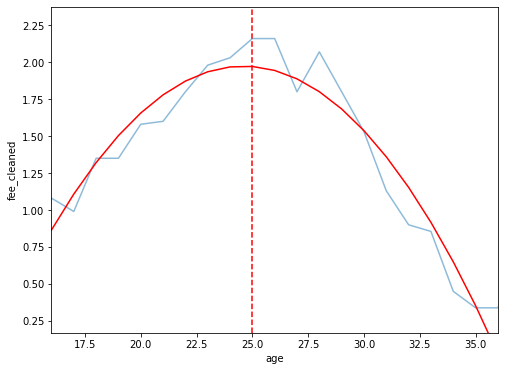

In [11]:
# visualize
fig, ax = plt.subplots(figsize = (8, 6))

sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.median, ci = None, alpha = 0.5)

xlim = (desc_stat.index[0], desc_stat.index[-1])
ylim = (min(desc_stat['median']*0.5), max(desc_stat['median'])*1.1)

# fit polynomial to smoothen the trend (for adjustment coefficient)
x = list(desc_stat['median'].index)
y = list(desc_stat['median'])

# smoothen the liner
fit = np.polyfit(x, y, deg = 2)
poly1d = np.poly1d(fit)

# add adjustment line
plt.plot(x, poly1d(x), '-', c = 'red')

# get the turning point (slope < 0)
idx = [idx for idx,val in enumerate(np.diff(poly1d(x))) if val < 0][0]

# add vertical line at the turning point
plt.vlines(x = x[idx], ymin = ylim[0], ymax = ylim[1],
           colors = 'red', linestyles = 'dashed')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [12]:
# develop adjustment coefficient
fitted_value = poly1d(x)

baseline = fitted_value[0]
base_value = np.divide(fitted_value, baseline)
coef = np.reciprocal(base_value)

temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index, 
                               'coef': coef})
temp_df

age       coef
0   16.0   1.000000
1   17.0   0.780784
2   18.0   0.654935
3   19.0   0.575268
4   20.0   0.522162
5   21.0   0.486086
6   22.0   0.461951
7   23.0   0.446917
8   24.0   0.439422
9   25.0   0.438745
10  26.0   0.444824
11  27.0   0.458237
12  28.0   0.480350
13  29.0   0.513690
14  30.0   0.562770
15  31.0   0.635933
16  32.0   0.749959
17  33.0   0.943698
18  34.0   1.331098
19  35.0   2.449770
20  36.0  32.801144

In [13]:
# extend age range to cover the data using lower-upper bound coefficient
age_df = pd.DataFrame(data = {'age': sorted(fee_age['age'].unique())})
adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
adj_coef_table

age       coef
0   15.0   1.000000
1   16.0   1.000000
2   17.0   0.780784
3   18.0   0.654935
4   19.0   0.575268
5   20.0   0.522162
6   21.0   0.486086
7   22.0   0.461951
8   23.0   0.446917
9   24.0   0.439422
10  25.0   0.438745
11  26.0   0.444824
12  27.0   0.458237
13  28.0   0.480350
14  29.0   0.513690
15  30.0   0.562770
16  31.0   0.635933
17  32.0   0.749959
18  33.0   0.943698
19  34.0   1.331098
20  35.0   2.449770
21  36.0  32.801144
22  37.0  32.801144
23  38.0  32.801144
24  39.0  32.801144

## Homophily-Performance Analysis

In [14]:
node_edge_df.head()

club_name        player_name   age        position  \
0  Fortuna Sittard        Rene Hofman  31.0    Right Winger   
1  Fortuna Sittard      Peter Schmitz  21.0         Forward   
2  Fortuna Sittard  Kenneth Nysaether  22.0  Centre-Forward   
3  Fortuna Sittard      Arno van Zwam  22.0      Goalkeeper   
4  Fortuna Sittard     Jerry Taihuttu  22.0  Centre-Forward   

  club_involved_name   fee transfer_movement  fee_cleaned  year  
0            Roda JC     ?                in          NaN  1992  
1      Helmond Sport     ?                in          NaN  1992  
2      Lillestrøm SK     ?                in          NaN  1992  
3        Fortuna U19     -                in          0.0  1992  
4      Helmond Sport  Loan               out          0.0  1992

### Create structured data

In [15]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_involved_name'].unique())

In [16]:
# define function to remove elements in a list from another list
def remove_elem_by_list(list1, list2):
    for elem in list2:
        try:
            list1.remove(elem)
        except Exception:
            pass
    return list1

In [17]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]
    
    # subset for transfer_movement == 'in', 'out' ---( in and out is opposite for `club_involved_name`)
    data_in = data[data['transfer_movement'] == 'out']
    data_out = data[data['transfer_movement'] == 'in']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club 
        temp_data_in = data_in[data_in['club_involved_name'] == club]
        temp_data_out = data_out[data_out['club_involved_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

### Performance Analysis (Fee)

In [18]:
perf_eval_df.head()

club_name      player_name   age            position  \
0     Ajax Amsterdam    Marc Overmars  19.0         Left Winger   
1     Ajax Amsterdam    Jari Litmanen  21.0  Attacking Midfield   
2     Ajax Amsterdam      Aron Winter  25.0  Defensive Midfield   
3   Sparta Rotterdam  Winston Bogarde  21.0         Centre-Back   
4  Willem II Tilburg    Marc Overmars  19.0         Left Winger   

  club_involved_name transfer_movement  fee_cleaned  year  
0          Willem II                in        0.817  1992  
1               MYPA                in        0.013  1992  
2              Lazio               out        1.170  1992  
3          Excelsior                in        0.005  1992  
4               Ajax               out        0.817  1992

In [19]:
adj_coef_table.head()

age      coef
0  15.0  1.000000
1  16.0  1.000000
2  17.0  0.780784
3  18.0  0.654935
4  19.0  0.575268

In [20]:
# add `adjusted_fee` column which adjusted for player's age
perf_eval_df = pd.merge(perf_eval_df, adj_coef_table, on = 'age', how = 'left')
perf_eval_df['adjusted_fee'] = np.multiply(perf_eval_df['fee_cleaned'], perf_eval_df['coef'])

# remove `coef` column
perf_eval_df.drop(columns = 'coef', inplace = True)
perf_eval_df

club_name       player_name   age            position  \
0           Ajax Amsterdam     Marc Overmars  19.0         Left Winger   
1           Ajax Amsterdam     Jari Litmanen  21.0  Attacking Midfield   
2           Ajax Amsterdam       Aron Winter  25.0  Defensive Midfield   
3         Sparta Rotterdam   Winston Bogarde  21.0         Centre-Back   
4        Willem II Tilburg     Marc Overmars  19.0         Left Winger   
...                    ...               ...   ...                 ...   
26883           Sevilla FC   Oussama Idrissi  24.0         Left Winger   
26884           Sevilla FC       Karim Rekik  25.0         Centre-Back   
26885      Athletic Bilbao    Alex Berenguer  25.0         Left Winger   
26886           Granada CF       Luis Suarez  22.0      Centre-Forward   
26887  Real Betis Balompié  Ismael Gutierrez  20.0    Central Midfield   

      club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  
0              Willem II                in        0.817  1992      0.469994  
1                   MYPA                in        0.013  1992      0.006319  
2                  Lazio               out        1.170  1992      0.513332  
3              Excelsior                in        0.005  1992      0.002430  
4                   Ajax               out        0.817  1992      0.469994  
...                  ...               ...          ...   ...           ...  
26883         AZ Alkmaar                in       10.800  2020      4.745754  
26884         Hertha BSC                in        1.800  2020      0.789741  
26885             Torino                in        9.450  2020      4.146140  
26886            Watford                in        6.300  2020      2.910294  
26887      Atl. Madrid B               out        0.900  2020      0.469946  

[26888 rows x 9 columns]

In [21]:
# subset only `transfer_movement` == 'out' to avoid double counting
df = perf_eval_df[perf_eval_df['transfer_movement'] == 'out']
df.reset_index(drop = True, inplace = True)
# clean the table
df.drop_duplicates(inplace = True)

In [22]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
df

club_name        player_name   age            position  \
0          Ajax Amsterdam        Aron Winter  25.0  Defensive Midfield   
1       Willem II Tilburg      Marc Overmars  19.0         Left Winger   
2          MVV Maastricht          Alloy Agu  24.0          Goalkeeper   
3      Twente Enschede FC       Arthur Numan  22.0           Left-Back   
4      Twente Enschede FC       Mitar Mrkela  26.0         Left Winger   
...                   ...                ...   ...                 ...   
11209    Deportivo Alavés  Ermedin Demirovic  22.0      Centre-Forward   
11210    Deportivo Alavés    Patrick Twumasi  26.0        Right Winger   
11211       Celta de Vigo        Pione Sisto  25.0         Left Winger   
11212            Elche CF          Juan Cruz  28.0           Left-Back   
11213            Elche CF          Oscar Gil  22.0          Right-Back   

      club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0                  Lazio               out        1.170  1992      0.513332   
1                   Ajax               out        0.817  1992      0.469994   
2             RC Lüttich               out        0.205  1992      0.090081   
3          PSV Eindhoven               out        1.150  1992      0.531244   
4               Besiktas               out        0.328  1992      0.145902   
...                  ...               ...          ...   ...           ...   
11209        SC Freiburg               out        3.330  2020      1.538298   
11210        Hannover 96               out        0.630  2020      0.280239   
11211     FC Midtjylland               out        2.250  2020      0.987176   
11212         CA Osasuna               out        2.480  2020      1.191268   
11213           Espanyol               out        0.450  2020      0.207878   

       num_transfer  max_transfer  
0                 1             2  
1                 1             3  
2                 1             1  
3                 1             2  
4                 1             1  
...             ...           ...  
11209             1             1  
11210             1             1  
11211             1             1  
11212             1             1  
11213             1             1  

[10942 rows x 11 columns]

In [23]:
# only select the players that have at least two transfers to see the improvement
target_player = list(df[df['num_transfer'] > 1]['player_name'])

df = df[df['player_name'].isin(target_player)]
df.reset_index(drop = True, inplace = True)
df

club_name       player_name   age            position  \
0             Ajax Amsterdam       Aron Winter  25.0  Defensive Midfield   
1          Willem II Tilburg     Marc Overmars  19.0         Left Winger   
2         Twente Enschede FC      Arthur Numan  22.0           Left-Back   
3     Cambuur-Leeuwarden bvo      Michael Mols  22.0      Centre-Forward   
4         Twente Enschede FC    Ronald de Boer  22.0        Right Winger   
...                      ...               ...   ...                 ...   
6084           Real Sociedad        Gero Rulli  28.0          Goalkeeper   
6085             Valencia CF           Rodrigo  29.0      Centre-Forward   
6086             Valencia CF  Francis Coquelin  29.0  Defensive Midfield   
6087     Real Betis Balompié  Giovani Lo Celso  24.0    Central Midfield   
6088     Real Betis Balompié    Zouhair Feddal  30.0         Centre-Back   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0                 Lazio               out        1.170  1992      0.513332   
1                  Ajax               out        0.817  1992      0.469994   
2         PSV Eindhoven               out        1.150  1992      0.531244   
3             Twente FC               out        0.491  1992      0.226818   
4                  Ajax               out        1.230  1992      0.568200   
...                 ...               ...          ...   ...           ...   
6084         Villarreal               out        4.500  2020      2.161574   
6085              Leeds               out       27.000  2020     13.869636   
6086         Villarreal               out        5.850  2020      3.005088   
6087              Spurs               out       28.800  2020     12.655343   
6088        Sporting CP               out        2.700  2020      1.519480   

      num_transfer  max_transfer  
0                1             2  
1                1             3  
2                1             2  
3                1             2  
4                1             3  
...            ...           ...  
6084             2             2  
6085             2             2  
6086             2             2  
6087             2             2  
6088             2             2  

[6089 rows x 11 columns]

In [24]:
# get player_list
player_list = list(df['player_name'].unique())

In [25]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_involved_name = temp_df.iloc[row]['club_involved_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            aff_players = nested_dict[year][club_involved_name]
            
            # add data to `year_member`
            year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_involved_name in aff_clubs.keys():
            
                aff_clubs[club_involved_name].update(year_member)
            
        else:
            
            aff_clubs[club_involved_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [26]:
was_in

{'Aron Winter': {'Lazio': {1992: ['Aron Winter',
    'Paul Gascoigne',
    'Diego Fuser',
    'Giuseppe Signori',
    'Roberto Cravero',
    'Luca Luzardi'],
   1993: ['Aron Winter',
    'Paul Gascoigne',
    'Diego Fuser',
    'Giuseppe Signori',
    'Roberto Cravero',
    'Luca Luzardi',
    'Alen Boksic',
    'Pierluigi Casiraghi',
    'Luca Marchegiani'],
   1994: ['Aron Winter',
    'Paul Gascoigne',
    'Diego Fuser',
    'Giuseppe Signori',
    'Roberto Cravero',
    'Alen Boksic',
    'Pierluigi Casiraghi',
    'Luca Marchegiani',
    'Jose Chamot',
    'Giorgio Venturin'],
   1995: ['Aron Winter',
    'Paul Gascoigne',
    'Diego Fuser',
    'Giuseppe Signori',
    'Alen Boksic',
    'Pierluigi Casiraghi',
    'Luca Marchegiani',
    'Jose Chamot'],
   1996: ['Paul Gascoigne',
    'Diego Fuser',
    'Giuseppe Signori',
    'Pierluigi Casiraghi',
    'Luca Marchegiani',
    'Jose Chamot',
    'Renato Buso',
    'Giorgio Venturin',
    'Marco Di Vaio'],
   1997: ['Paul Gascoigne

In [27]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
df

club_name         player_name   age            position  \
0        Newcastle United        Aaron Hughes  25.0         Centre-Back   
1             Aston Villa        Aaron Hughes  27.0         Centre-Back   
2            Leeds United        Aaron Lennon  18.0        Right Winger   
3       Tottenham Hotspur        Aaron Lennon  28.0        Right Winger   
4              Everton FC        Aaron Lennon  30.0        Right Winger   
...                   ...                 ...   ...                 ...   
6084  Bayer 04 Leverkusen         Zoran Mamic  28.0         Centre-Back   
6085     Deportivo Alavés      Zouhair Feddal  27.0         Centre-Back   
6086  Real Betis Balompié      Zouhair Feddal  30.0         Centre-Back   
6087        VfL Wolfsburg  Zvjezdan Misimovic  28.0  Attacking Midfield   
6088        Dynamo Moscow  Zvjezdan Misimovic  30.0  Attacking Midfield   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0           Aston Villa               out         1.35  2005      0.592306   
1                Fulham               out         1.35  2007      0.618620   
2                 Spurs               out         1.08  2005      0.707329   
3               Everton               out         5.40  2015      2.593889   
4               Burnley               out         1.53  2017      0.861038   
...                 ...               ...          ...   ...           ...   
6084         VfL Bochum               out         0.45  2000      0.216157   
6085         Real Betis               out         2.25  2017      1.031033   
6086        Sporting CP               out         2.70  2020      1.519480   
6087        Galatasaray               out         7.65  2010      3.674676   
6088           GZ Renhe               out         3.15  2012      1.772726   

      num_transfer  max_transfer  
0                1             2  
1                2             2  
2                1             3  
3                2             3  
4                3             3  
...            ...           ...  
6084             2             2  
6085             1             2  
6086             2             2  
6087             1             2  
6088             2             2  

[6089 rows x 11 columns]

In [28]:
# get number of years in the club
num_year_stay = []
for i in range(len(df)):
    if df['num_transfer'][i] < df['max_transfer'][i]:
        val = df['year'][i+1] - df['year'][i]
        num_year_stay.append(val)
    else:
        num_year_stay.append(None)
df['num_year_stay'] = num_year_stay
df
    
# due to the limitation of the data (not fully cleaned), we cannot get the number of year if
# there is no further transaction

club_name         player_name   age            position  \
0        Newcastle United        Aaron Hughes  25.0         Centre-Back   
1             Aston Villa        Aaron Hughes  27.0         Centre-Back   
2            Leeds United        Aaron Lennon  18.0        Right Winger   
3       Tottenham Hotspur        Aaron Lennon  28.0        Right Winger   
4              Everton FC        Aaron Lennon  30.0        Right Winger   
...                   ...                 ...   ...                 ...   
6084  Bayer 04 Leverkusen         Zoran Mamic  28.0         Centre-Back   
6085     Deportivo Alavés      Zouhair Feddal  27.0         Centre-Back   
6086  Real Betis Balompié      Zouhair Feddal  30.0         Centre-Back   
6087        VfL Wolfsburg  Zvjezdan Misimovic  28.0  Attacking Midfield   
6088        Dynamo Moscow  Zvjezdan Misimovic  30.0  Attacking Midfield   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0           Aston Villa               out         1.35  2005      0.592306   
1                Fulham               out         1.35  2007      0.618620   
2                 Spurs               out         1.08  2005      0.707329   
3               Everton               out         5.40  2015      2.593889   
4               Burnley               out         1.53  2017      0.861038   
...                 ...               ...          ...   ...           ...   
6084         VfL Bochum               out         0.45  2000      0.216157   
6085         Real Betis               out         2.25  2017      1.031033   
6086        Sporting CP               out         2.70  2020      1.519480   
6087        Galatasaray               out         7.65  2010      3.674676   
6088           GZ Renhe               out         3.15  2012      1.772726   

      num_transfer  max_transfer  num_year_stay  
0                1             2            2.0  
1                2             2            NaN  
2                1             3           10.0  
3                2             3            2.0  
4                3             3            NaN  
...            ...           ...            ...  
6084             2             2            NaN  
6085             1             2            3.0  
6086             2             2            NaN  
6087             1             2            2.0  
6088             2             2            NaN  

[6089 rows x 12 columns]

In [29]:
# generate `k` column

# initiate a list
k = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        
    else:  
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_involved_name'][i-1]
        club = df['club_involved_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            aff_player = was_in[player][prev_club][year]
            aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_val`
        k_val = len(set.intersection(set(aff_players), set(in_club_player)))
        
        # append `k_val` to `k`
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k

In [30]:
# change in fee as a proxy of performance --> `perf_change`
df['perf_change'] = df.groupby('player_name')['fee_cleaned'].pct_change()

In [31]:
# change in adjusted fee as a proxy of performance --> `perf_change_adjusted`
df['perf_change_adjusted'] = df.groupby('player_name')['adjusted_fee'].pct_change()

In [32]:
df

club_name         player_name   age            position  \
0        Newcastle United        Aaron Hughes  25.0         Centre-Back   
1             Aston Villa        Aaron Hughes  27.0         Centre-Back   
2            Leeds United        Aaron Lennon  18.0        Right Winger   
3       Tottenham Hotspur        Aaron Lennon  28.0        Right Winger   
4              Everton FC        Aaron Lennon  30.0        Right Winger   
...                   ...                 ...   ...                 ...   
6084  Bayer 04 Leverkusen         Zoran Mamic  28.0         Centre-Back   
6085     Deportivo Alavés      Zouhair Feddal  27.0         Centre-Back   
6086  Real Betis Balompié      Zouhair Feddal  30.0         Centre-Back   
6087        VfL Wolfsburg  Zvjezdan Misimovic  28.0  Attacking Midfield   
6088        Dynamo Moscow  Zvjezdan Misimovic  30.0  Attacking Midfield   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0           Aston Villa               out         1.35  2005      0.592306   
1                Fulham               out         1.35  2007      0.618620   
2                 Spurs               out         1.08  2005      0.707329   
3               Everton               out         5.40  2015      2.593889   
4               Burnley               out         1.53  2017      0.861038   
...                 ...               ...          ...   ...           ...   
6084         VfL Bochum               out         0.45  2000      0.216157   
6085         Real Betis               out         2.25  2017      1.031033   
6086        Sporting CP               out         2.70  2020      1.519480   
6087        Galatasaray               out         7.65  2010      3.674676   
6088           GZ Renhe               out         3.15  2012      1.772726   

      num_transfer  max_transfer  num_year_stay    k  perf_change  \
0                1             2            2.0  NaN          NaN   
1                2             2            NaN  1.0     0.000000   
2                1             3           10.0  NaN          NaN   
3                2             3            2.0  2.0     4.000000   
4                3             3            NaN  4.0    -0.716667   
...            ...           ...            ...  ...          ...   
6084             2             2            NaN  1.0    -0.375000   
6085             1             2            3.0  NaN          NaN   
6086             2             2            NaN  2.0     0.200000   
6087             1             2            2.0  NaN          NaN   
6088             2             2            NaN  0.0    -0.588235   

      perf_change_adjusted  
0                      NaN  
1                 0.044427  
2                      NaN  
3                 2.667159  
4                -0.668051  
...                    ...  
6084             -0.325084  
6085                   NaN  
6086              0.473744  
6087                   NaN  
6088             -0.517583  

[6089 rows x 15 columns]

In [33]:
# average number of year stayed by k
for_num_year = df[['num_year_stay', 'k']].dropna()

In [34]:
num_year_df = pd.DataFrame(for_num_year.groupby('k')['num_year_stay'].agg(['mean', 'count'])).reset_index()
num_year_df.head()

k      mean  count
0  0.0  2.144330     97
1  1.0  2.666667    681
2  2.0  2.507853    191
3  3.0  2.035714     84
4  4.0  2.281250     32

In [35]:
# get `k-perf` table
k_perf = df[['k', 'perf_change', 'perf_change_adjusted']].dropna()
k_perf

k  perf_change  perf_change_adjusted
1     1.0     0.000000              0.044427
3     2.0     4.000000              2.667159
4     4.0    -0.716667             -0.668051
6     1.0    -0.162963             -0.162963
8     3.0    -0.637363             -0.581220
...   ...          ...                   ...
6080  1.0     0.200000              0.236185
6082  1.0    -0.722222             -0.715186
6084  1.0    -0.375000             -0.325084
6086  2.0     0.200000              0.473744
6088  0.0    -0.588235             -0.517583

[3624 rows x 3 columns]

In [36]:
k_perf.sort_values(by = 'k', ascending = False)

k  perf_change  perf_change_adjusted
2930  106.0    -0.666667             -0.573098
3830   90.0     0.285714              0.303528
5066   89.0    -0.465000             -0.508110
3616   85.0    -0.300000             -0.268901
3981   84.0     0.076923             -0.090029
...     ...          ...                   ...
2823    0.0    -0.416667             -0.408585
4186    0.0    -0.416667             -0.416667
994     0.0     1.200000              1.200000
2817    0.0     0.800000              0.800000
6088    0.0    -0.588235             -0.517583

[3624 rows x 3 columns]

In [37]:
pd.DataFrame(k_perf.groupby('k')['perf_change'].agg(['median', 'count'])).reset_index()

k    median  count
0     0.0  0.000000    246
1     1.0  0.000000   2087
2     2.0  0.000000    655
3     3.0 -0.068504    258
4     4.0 -0.061111    103
..    ...       ...    ...
58   84.0  0.076923      1
59   85.0 -0.300000      1
60   89.0 -0.465000      1
61   90.0  0.285714      1
62  106.0 -0.666667      1

[63 rows x 3 columns]

In [38]:
pd.DataFrame(k_perf.groupby('k')['perf_change_adjusted'].agg(['median', 'count'])).reset_index()

k    median  count
0     0.0  0.000000    246
1     1.0  0.030154   2087
2     2.0  0.042819    655
3     3.0 -0.027400    258
4     4.0  0.038771    103
..    ...       ...    ...
58   84.0 -0.090029      1
59   85.0 -0.268901      1
60   89.0 -0.508110      1
61   90.0  0.303528      1
62  106.0 -0.573098      1

[63 rows x 3 columns]

#### Visualization

In [39]:
# get average perf_change by k
table = pd.DataFrame(k_perf.groupby('k')['perf_change']\
                     .agg(['mean', 'median', 'mad', 'count'])).reset_index()

In [40]:
# get average perf_change_adjusted by k
table2 = pd.DataFrame(k_perf.groupby('k')['perf_change_adjusted']\
                      .agg(['mean', 'median', 'mad', 'count'])).reset_index()

In [41]:
# get the index where `count` >= 30
xmax = max(table[table['count'] >= 30].index)

table = table[:xmax+1]
table2 = table2[:xmax+1]

In [42]:
# set-up
table.rename(columns = {'median': 'med_perf_change'}, inplace = True)
table

k      mean  med_perf_change       mad  count
0  0.0  1.179864         0.000000  2.103960    246
1  1.0  2.390204         0.000000  3.947252   2087
2  2.0  1.500757         0.000000  2.551551    655
3  3.0  0.856428        -0.068504  1.676649    258
4  4.0  1.835709        -0.061111  3.162017    103
5  5.0  1.870897        -0.248038  3.450667     68
6  6.0  0.072152        -0.172881  0.614985     36

In [43]:
# set-up
table2.rename(columns = {'median': 'med_perf_change'}, inplace = True)
table2

k      mean  med_perf_change       mad  count
0  0.0  1.159907         0.000000  2.044965    246
1  1.0  2.263200         0.030154  3.662471   2087
2  2.0  1.721707         0.042819  2.787288    655
3  3.0  0.893304        -0.027400  1.640891    258
4  4.0  2.028036         0.038771  3.308565    103
5  5.0  1.724451        -0.136764  3.048942     68
6  6.0  0.149270        -0.083526  0.657858     36

In [44]:
# set-up
num_year_df = num_year_df[:xmax+1]
num_year_df.rename(columns = {'mean': 'average_year_stayed'}, inplace = True)
num_year_df

k  average_year_stayed  count
0  0.0             2.144330     97
1  1.0             2.666667    681
2  2.0             2.507853    191
3  3.0             2.035714     84
4  4.0             2.281250     32
5  5.0             2.500000     20
6  6.0             2.166667     12

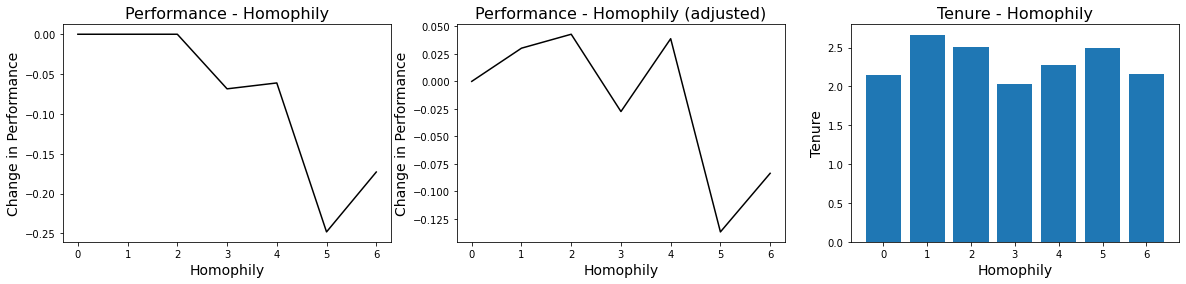

In [45]:
fig = plt.figure(figsize = (20, 4))

ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

ax0.plot(table['k'],
         table['med_perf_change'],
         color = 'black')

ax0.set_xlabel('Homophily', size = 14)
ax0.set_ylabel('Change in Performance', size = 14)
ax0.set_title('Performance - Homophily', size = 16)

# get x limit
ylim = ax0.get_ylim()

# ax0.set_xlim((0,xmax))
# ax0.set_ylim((-1,1))

ax1.plot(table['k'],
         table2['med_perf_change'],
         color = 'black')

ax1.set_xlabel('Homophily', size = 14)
ax1.set_ylabel('Change in Performance', size = 14)
ax1.set_title('Performance - Homophily (adjusted)', size = 16)

# ax1.set_xlim((0,xmax))
# ax1.set_ylim(ylim)

ax2.bar(x = num_year_df['k'],
        height = num_year_df['average_year_stayed'])

ax2.set_xlabel('Homophily', size = 14)
ax2.set_ylabel('Tenure', size = 14)
ax2.set_title('Tenure - Homophily', size = 16)

# ax2.set_xlim((-1,xmax))

plt.show()

### Test the existence of homophily

#### Null case simulation
The data is not cleaned but we try to imitate the dataset in the most random manner as possible

In [46]:
# load data
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [47]:
#select only necessary columns
data_simul = node_edge_df[['player_name', 'club_involved_name', 'transfer_movement', 'year']]

In [58]:
len(data_simul)

158327

In [70]:
# set-up

player_name_list = data_simul['player_name'].unique()
club_involved_name_list = data_simul['club_involved_name'].unique()
year_list = data_simul['year'].unique()

# in-out distribution (just get the `out` and multiply by 2: assume that the data is cleaned)
out_num = sum(data_simul['transfer_movement'] == 'out')

# number of movement distribution
num_move = pd.DataFrame(data_simul.groupby(['player_name', 'year'])['transfer_movement'].agg('count'))
num_move['count'] = 1
num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
num_move = pd.DataFrame(num_move).reset_index()
num_move['transfer_movement'] = [math.ceil(num/2) for num in num_move['transfer_movement']]
num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
num_move = num_move / np.sum(num_move)
num_move = round(num_move * out_num)
num_move = pd.DataFrame(num_move).reset_index()

In [72]:
# get column names
col_names = data_simul.columns

# simulate data
rows = []
for t, count in zip(num_move['transfer_movement'], num_move['count']):
    for i in tqdm(range(int(count))):
        # get each column value
        player_name = np.repeat(np.random.choice(player_name_list, 1), t)
        club_involved_name = np.random.choice(club_involved_name_list, t, replace = False)
        transfer_movement = np.repeat('out', t)
        year = np.random.choice(year_list, t, replace = False)
        # format data
        row = list(zip(player_name, club_involved_name, transfer_movement, year))
        # add to the list
        rows.extend(row)

# create dataframe
null_case = pd.DataFrame(data = rows, columns = col_names)
null_case.head()

player_name club_involved_name transfer_movement  year
0    Goncalo Silva            Náutico               out  2004
1  Gregory Tanagro          Droylsden               out  2016
2     Jamie Menagh    Bidvest Wits FC               out  1995
3    Anto Drobnjak      Sheff Wed U23               out  2018
4     Guram Kashia           Racing B               out  2009

In [73]:
# sort data
null_case = null_case.sort_values(by = ['player_name', 'year'])

# add column `num_transfer` which represent the number of time a player moved
null_case['count'] = 1
null_case['num_transfer'] = null_case.groupby('player_name')['count'].cumcount() + 1
null_case['max_transfer'] = null_case.groupby('player_name')['num_transfer'].transform(np.max)
null_case.drop(columns = 'count', inplace = True)
null_case.reset_index(drop = True, inplace = True)
null_case

player_name     club_involved_name transfer_movement  year  \
0               Aadil Assana              DHC Delft               out  1994   
1               Aadil Assana             Alavés U19               out  2004   
2               Aadil Assana                    Ufa               out  2015   
3                 Aapo Halme  Hong Kong Golden Team               out  1995   
4                 Aapo Halme                Kryvbas               out  1996   
...                      ...                    ...               ...   ...   
93047           Zvonko Pamic          APS Zakynthos               out  2012   
93048           Zvonko Pamic            HSK Posusje               out  2016   
93049  Zydrunas Karcemarskas           Al-Duhail SC               out  1998   
93050  Zydrunas Karcemarskas         Farsley Celtic               out  1999   
93051  Zydrunas Karcemarskas           Metalurgi R.               out  2015   

       num_transfer  max_transfer  
0                 1             3  
1                 2             3  
2                 3             3  
3                 1             8  
4                 2             8  
...             ...           ...  
93047             3             4  
93048             4             4  
93049             1             3  
93050             2             3  
93051             3             3  

[93052 rows x 6 columns]

In [74]:
# add `transfer_movement` == 'in'
to_add = []
for i in tqdm(range(len(null_case))):
    if (null_case.iloc[i]['num_transfer'] > 1) & \
    (null_case.iloc[i]['num_transfer'] < null_case.iloc[i]['max_transfer']):
        # create the 'in' case
        row = list(null_case.iloc[i].replace('out', 'in'))
        # add to `to_add` list
        to_add.append(row)
        
# add data to dataframe
extend = pd.DataFrame(data = to_add, columns = null_case.columns)
null_case = pd.concat([null_case, extend], axis = 0).reset_index(drop = True)
null_case.drop(columns = ['num_transfer', 'max_transfer'], inplace = True)
null_case.sort_values(by = ['player_name', 'year']).reset_index(drop = True, inplace = True)
null_case

player_name     club_involved_name transfer_movement  year
0                Aadil Assana              DHC Delft               out  1994
1                Aadil Assana             Alavés U19               out  2004
2                Aadil Assana                    Ufa               out  2015
3                  Aapo Halme  Hong Kong Golden Team               out  1995
4                  Aapo Halme                Kryvbas               out  1996
...                       ...                    ...               ...   ...
131990         Zvonimir Vukic                  Boden                in  1998
131991         Zvonimir Vukic            SC Enschede                in  2003
131992           Zvonko Pamic              Fabus Br.                in  1998
131993           Zvonko Pamic          APS Zakynthos                in  2012
131994  Zydrunas Karcemarskas         Farsley Celtic                in  1999

[131995 rows x 4 columns]

#### Null case analysis

In [75]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(null_case['year'].unique()))
club_list = sorted(null_case['club_involved_name'].unique())

In [76]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = null_case[null_case['year'] == year]
    
    # subset for transfer_movement == 'in', 'out' ---( in and out is opposite for `club_involved_name`)
    data_in = data[data['transfer_movement'] == 'out']
    data_out = data[data['transfer_movement'] == 'in']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club 
        temp_data_in = data_in[data_in['club_involved_name'] == club]
        temp_data_out = data_out[data_out['club_involved_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

In [77]:
# add `adjusted_fee` column which adjusted for player's age
perf_eval_df = pd.merge(perf_eval_df, adj_coef_table, on = 'age', how = 'left')
perf_eval_df['adjusted_fee'] = np.multiply(perf_eval_df['fee_cleaned'], perf_eval_df['coef'])

# remove `coef` column
perf_eval_df.drop(columns = 'coef', inplace = True)
perf_eval_df

club_name       player_name   age            position  \
0           Ajax Amsterdam     Marc Overmars  19.0         Left Winger   
1           Ajax Amsterdam     Jari Litmanen  21.0  Attacking Midfield   
2           Ajax Amsterdam       Aron Winter  25.0  Defensive Midfield   
3         Sparta Rotterdam   Winston Bogarde  21.0         Centre-Back   
4        Willem II Tilburg     Marc Overmars  19.0         Left Winger   
...                    ...               ...   ...                 ...   
26883           Sevilla FC   Oussama Idrissi  24.0         Left Winger   
26884           Sevilla FC       Karim Rekik  25.0         Centre-Back   
26885      Athletic Bilbao    Alex Berenguer  25.0         Left Winger   
26886           Granada CF       Luis Suarez  22.0      Centre-Forward   
26887  Real Betis Balompié  Ismael Gutierrez  20.0    Central Midfield   

      club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  
0              Willem II                in        0.817  1992      0.469994  
1                   MYPA                in        0.013  1992      0.006319  
2                  Lazio               out        1.170  1992      0.513332  
3              Excelsior                in        0.005  1992      0.002430  
4                   Ajax               out        0.817  1992      0.469994  
...                  ...               ...          ...   ...           ...  
26883         AZ Alkmaar                in       10.800  2020      4.745754  
26884         Hertha BSC                in        1.800  2020      0.789741  
26885             Torino                in        9.450  2020      4.146140  
26886            Watford                in        6.300  2020      2.910294  
26887      Atl. Madrid B               out        0.900  2020      0.469946  

[26888 rows x 9 columns]

In [78]:
# subset only `transfer_movement` == 'out' to avoid double counting
df = perf_eval_df[perf_eval_df['transfer_movement'] == 'out']
df.reset_index(drop = True, inplace = True)
# clean the table
df.drop_duplicates(inplace = True)

In [79]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
df

club_name        player_name   age            position  \
0          Ajax Amsterdam        Aron Winter  25.0  Defensive Midfield   
1       Willem II Tilburg      Marc Overmars  19.0         Left Winger   
2          MVV Maastricht          Alloy Agu  24.0          Goalkeeper   
3      Twente Enschede FC       Arthur Numan  22.0           Left-Back   
4      Twente Enschede FC       Mitar Mrkela  26.0         Left Winger   
...                   ...                ...   ...                 ...   
11209    Deportivo Alavés  Ermedin Demirovic  22.0      Centre-Forward   
11210    Deportivo Alavés    Patrick Twumasi  26.0        Right Winger   
11211       Celta de Vigo        Pione Sisto  25.0         Left Winger   
11212            Elche CF          Juan Cruz  28.0           Left-Back   
11213            Elche CF          Oscar Gil  22.0          Right-Back   

      club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0                  Lazio               out        1.170  1992      0.513332   
1                   Ajax               out        0.817  1992      0.469994   
2             RC Lüttich               out        0.205  1992      0.090081   
3          PSV Eindhoven               out        1.150  1992      0.531244   
4               Besiktas               out        0.328  1992      0.145902   
...                  ...               ...          ...   ...           ...   
11209        SC Freiburg               out        3.330  2020      1.538298   
11210        Hannover 96               out        0.630  2020      0.280239   
11211     FC Midtjylland               out        2.250  2020      0.987176   
11212         CA Osasuna               out        2.480  2020      1.191268   
11213           Espanyol               out        0.450  2020      0.207878   

       num_transfer  max_transfer  
0                 1             2  
1                 1             3  
2                 1             1  
3                 1             2  
4                 1             1  
...             ...           ...  
11209             1             1  
11210             1             1  
11211             1             1  
11212             1             1  
11213             1             1  

[10942 rows x 11 columns]

In [80]:
# only select the players that have at least two transfers to see the improvement
target_player = list(df[df['num_transfer'] > 1]['player_name'])

df = df[df['player_name'].isin(target_player)]
df.reset_index(drop = True, inplace = True)
df

club_name       player_name   age            position  \
0             Ajax Amsterdam       Aron Winter  25.0  Defensive Midfield   
1          Willem II Tilburg     Marc Overmars  19.0         Left Winger   
2         Twente Enschede FC      Arthur Numan  22.0           Left-Back   
3     Cambuur-Leeuwarden bvo      Michael Mols  22.0      Centre-Forward   
4         Twente Enschede FC    Ronald de Boer  22.0        Right Winger   
...                      ...               ...   ...                 ...   
6084           Real Sociedad        Gero Rulli  28.0          Goalkeeper   
6085             Valencia CF           Rodrigo  29.0      Centre-Forward   
6086             Valencia CF  Francis Coquelin  29.0  Defensive Midfield   
6087     Real Betis Balompié  Giovani Lo Celso  24.0    Central Midfield   
6088     Real Betis Balompié    Zouhair Feddal  30.0         Centre-Back   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0                 Lazio               out        1.170  1992      0.513332   
1                  Ajax               out        0.817  1992      0.469994   
2         PSV Eindhoven               out        1.150  1992      0.531244   
3             Twente FC               out        0.491  1992      0.226818   
4                  Ajax               out        1.230  1992      0.568200   
...                 ...               ...          ...   ...           ...   
6084         Villarreal               out        4.500  2020      2.161574   
6085              Leeds               out       27.000  2020     13.869636   
6086         Villarreal               out        5.850  2020      3.005088   
6087              Spurs               out       28.800  2020     12.655343   
6088        Sporting CP               out        2.700  2020      1.519480   

      num_transfer  max_transfer  
0                1             2  
1                1             3  
2                1             2  
3                1             2  
4                1             3  
...            ...           ...  
6084             2             2  
6085             2             2  
6086             2             2  
6087             2             2  
6088             2             2  

[6089 rows x 11 columns]

In [81]:
# only select the players that have at least two transfers to see the improvement
target_player = list(df[df['num_transfer'] > 1]['player_name'])

df = df[df['player_name'].isin(target_player)]
df.reset_index(drop = True, inplace = True)
df

club_name       player_name   age            position  \
0             Ajax Amsterdam       Aron Winter  25.0  Defensive Midfield   
1          Willem II Tilburg     Marc Overmars  19.0         Left Winger   
2         Twente Enschede FC      Arthur Numan  22.0           Left-Back   
3     Cambuur-Leeuwarden bvo      Michael Mols  22.0      Centre-Forward   
4         Twente Enschede FC    Ronald de Boer  22.0        Right Winger   
...                      ...               ...   ...                 ...   
6084           Real Sociedad        Gero Rulli  28.0          Goalkeeper   
6085             Valencia CF           Rodrigo  29.0      Centre-Forward   
6086             Valencia CF  Francis Coquelin  29.0  Defensive Midfield   
6087     Real Betis Balompié  Giovani Lo Celso  24.0    Central Midfield   
6088     Real Betis Balompié    Zouhair Feddal  30.0         Centre-Back   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0                 Lazio               out        1.170  1992      0.513332   
1                  Ajax               out        0.817  1992      0.469994   
2         PSV Eindhoven               out        1.150  1992      0.531244   
3             Twente FC               out        0.491  1992      0.226818   
4                  Ajax               out        1.230  1992      0.568200   
...                 ...               ...          ...   ...           ...   
6084         Villarreal               out        4.500  2020      2.161574   
6085              Leeds               out       27.000  2020     13.869636   
6086         Villarreal               out        5.850  2020      3.005088   
6087              Spurs               out       28.800  2020     12.655343   
6088        Sporting CP               out        2.700  2020      1.519480   

      num_transfer  max_transfer  
0                1             2  
1                1             3  
2                1             2  
3                1             2  
4                1             3  
...            ...           ...  
6084             2             2  
6085             2             2  
6086             2             2  
6087             2             2  
6088             2             2  

[6089 rows x 11 columns]

In [82]:
# get player_list
player_list = list(df['player_name'].unique())

In [83]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_involved_name = temp_df.iloc[row]['club_involved_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            aff_players = nested_dict[year][club_involved_name]
            
            # add data to `year_member`
            year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_involved_name in aff_clubs.keys():
            
                aff_clubs[club_involved_name].update(year_member)
            
        else:
            
            aff_clubs[club_involved_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [84]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
df

club_name         player_name   age            position  \
0        Newcastle United        Aaron Hughes  25.0         Centre-Back   
1             Aston Villa        Aaron Hughes  27.0         Centre-Back   
2            Leeds United        Aaron Lennon  18.0        Right Winger   
3       Tottenham Hotspur        Aaron Lennon  28.0        Right Winger   
4              Everton FC        Aaron Lennon  30.0        Right Winger   
...                   ...                 ...   ...                 ...   
6084  Bayer 04 Leverkusen         Zoran Mamic  28.0         Centre-Back   
6085     Deportivo Alavés      Zouhair Feddal  27.0         Centre-Back   
6086  Real Betis Balompié      Zouhair Feddal  30.0         Centre-Back   
6087        VfL Wolfsburg  Zvjezdan Misimovic  28.0  Attacking Midfield   
6088        Dynamo Moscow  Zvjezdan Misimovic  30.0  Attacking Midfield   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0           Aston Villa               out         1.35  2005      0.592306   
1                Fulham               out         1.35  2007      0.618620   
2                 Spurs               out         1.08  2005      0.707329   
3               Everton               out         5.40  2015      2.593889   
4               Burnley               out         1.53  2017      0.861038   
...                 ...               ...          ...   ...           ...   
6084         VfL Bochum               out         0.45  2000      0.216157   
6085         Real Betis               out         2.25  2017      1.031033   
6086        Sporting CP               out         2.70  2020      1.519480   
6087        Galatasaray               out         7.65  2010      3.674676   
6088           GZ Renhe               out         3.15  2012      1.772726   

      num_transfer  max_transfer  
0                1             2  
1                2             2  
2                1             3  
3                2             3  
4                3             3  
...            ...           ...  
6084             2             2  
6085             1             2  
6086             2             2  
6087             1             2  
6088             2             2  

[6089 rows x 11 columns]

In [85]:
# get number of years in the club
num_year_stay = []
for i in range(len(df)):
    if df['num_transfer'][i] < df['max_transfer'][i]:
        val = df['year'][i+1] - df['year'][i]
        num_year_stay.append(val)
    else:
        num_year_stay.append(None)
df['num_year_stay'] = num_year_stay
df
    
# due to the limitation of the data (not fully cleaned), we cannot get the number of year if
# there is no further transaction

club_name         player_name   age            position  \
0        Newcastle United        Aaron Hughes  25.0         Centre-Back   
1             Aston Villa        Aaron Hughes  27.0         Centre-Back   
2            Leeds United        Aaron Lennon  18.0        Right Winger   
3       Tottenham Hotspur        Aaron Lennon  28.0        Right Winger   
4              Everton FC        Aaron Lennon  30.0        Right Winger   
...                   ...                 ...   ...                 ...   
6084  Bayer 04 Leverkusen         Zoran Mamic  28.0         Centre-Back   
6085     Deportivo Alavés      Zouhair Feddal  27.0         Centre-Back   
6086  Real Betis Balompié      Zouhair Feddal  30.0         Centre-Back   
6087        VfL Wolfsburg  Zvjezdan Misimovic  28.0  Attacking Midfield   
6088        Dynamo Moscow  Zvjezdan Misimovic  30.0  Attacking Midfield   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
0           Aston Villa               out         1.35  2005      0.592306   
1                Fulham               out         1.35  2007      0.618620   
2                 Spurs               out         1.08  2005      0.707329   
3               Everton               out         5.40  2015      2.593889   
4               Burnley               out         1.53  2017      0.861038   
...                 ...               ...          ...   ...           ...   
6084         VfL Bochum               out         0.45  2000      0.216157   
6085         Real Betis               out         2.25  2017      1.031033   
6086        Sporting CP               out         2.70  2020      1.519480   
6087        Galatasaray               out         7.65  2010      3.674676   
6088           GZ Renhe               out         3.15  2012      1.772726   

      num_transfer  max_transfer  num_year_stay  
0                1             2            2.0  
1                2             2            NaN  
2                1             3           10.0  
3                2             3            2.0  
4                3             3            NaN  
...            ...           ...            ...  
6084             2             2            NaN  
6085             1             2            3.0  
6086             2             2            NaN  
6087             1             2            2.0  
6088             2             2            NaN  

[6089 rows x 12 columns]

In [86]:
# generate `k` column

# initiate a list
k = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        
    else:  
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_involved_name'][i-1]
        club = df['club_involved_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            aff_player = was_in[player][prev_club][year]
            aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_val`
        k_val = len(set.intersection(set(aff_players), set(in_club_player)))
        
        # append `k_val` to `k`
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k

In [87]:
# change in fee as a proxy of performance --> `perf_change`
df['perf_change'] = df.groupby('player_name')['fee_cleaned'].pct_change()

In [88]:
# change in adjusted fee as a proxy of performance --> `perf_change_adjusted`
df['perf_change_adjusted'] = df.groupby('player_name')['adjusted_fee'].pct_change()

In [89]:
# average number of year stayed by k
for_num_year = df[['num_year_stay', 'k']].dropna()

In [90]:
num_year_df = pd.DataFrame(for_num_year.groupby('k')['num_year_stay'].agg(['mean', 'count'])).reset_index()
num_year_df.head()

k      mean  count
0  0.0  2.516696   1138
1  1.0  2.500000      2
2  2.0  3.000000      2
3  3.0  3.400000      5
4  4.0  4.000000      1

In [91]:
# get `k-perf` table
k_perf = df[['k', 'perf_change', 'perf_change_adjusted']].dropna()
k_perf

k  perf_change  perf_change_adjusted
1     0.0     0.000000              0.044427
3     0.0     4.000000              2.667159
4     0.0    -0.716667             -0.668051
6     0.0    -0.162963             -0.162963
8     0.0    -0.637363             -0.581220
...   ...          ...                   ...
6080  0.0     0.200000              0.236185
6082  0.0    -0.722222             -0.715186
6084  0.0    -0.375000             -0.325084
6086  0.0     0.200000              0.473744
6088  0.0    -0.588235             -0.517583

[3624 rows x 3 columns]

In [92]:
"""
CONTINUE HERE
"""

'\nCONTINUE HERE\n'

## Top player similarity analysis

In [93]:
rating_df = pd.read_csv(os.path.join(cleaned_data_path, 'player_rating.csv'))

In [94]:
rating_eval_df = pd.merge(perf_eval_df, rating_df, on = ['player_name', 'year'], how = 'inner')

In [95]:
rating_eval_df = pd.DataFrame(rating_eval_df.groupby(['player_name', 'age', 'position'])['overall_rating'].agg('mean'))
rating_eval_df.reset_index(inplace = True)
top_player_list = rating_eval_df[rating_eval_df['overall_rating'] > 85]['player_name'].unique()
top_player_list

array(['Angel Di Maria', 'Arjen Robben', 'Arturo Vidal',
       'Bastian Schweinsteiger', 'Carlos Tevez', 'Cesc Fabregas',
       'Cristiano Ronaldo', 'David Silva', 'David Villa',
       'Dimitar Berbatov', 'Eden Hazard', 'Edinson Cavani',
       'Ezequiel Lavezzi', 'Fernando Torres', 'Franck Ribery',
       'Gabriel Milito', 'Gareth Bale', 'Gonzalo Higuain', 'Hugo Lloris',
       'James Rodriguez', 'Juan Mata', 'Luca Toni', 'Lucio',
       'Luis Suarez', 'Luka Modric', 'Manuel Neuer', 'Mario Gomez',
       'Mats Hummels', 'Miroslav Klose', 'Paul Pogba',
       'Rafael van der Vaart', 'Robin van Persie', 'Ronaldinho',
       'Roy Makaay', 'Samir Nasri', "Samuel Eto'o", 'Sergio Aguero',
       'Thiago Silva', 'Thierry Henry', 'Wesley Sneijder', 'Ze Roberto',
       'Zlatan Ibrahimovic'], dtype=object)

In [96]:
top_eval = df[df['player_name'].isin(top_player_list)]

In [97]:
top_eval[top_eval['num_transfer'] >= 3][['club_name', 'player_name', 'age', 'year', 'club_involved_name', 'adjusted_fee','k', 'perf_change_adjusted']].sort_values(by = 'year')

club_name           player_name   age  year club_involved_name  \
578          Chelsea FC          Arjen Robben  23.0  2007        Real Madrid   
5680         Arsenal FC         Thierry Henry  29.0  2007       FC Barcelona   
5116      Bayern Munich            Roy Makaay  32.0  2007          Feyenoord   
3469     ACF Fiorentina             Luca Toni  30.0  2007      Bayern Munich   
579         Real Madrid          Arjen Robben  25.0  2009      Bayern Munich   
5204       FC Barcelona          Samuel Eto'o  28.0  2009              Inter   
5090           AC Milan            Ronaldinho  30.0  2010           Flamengo   
4821        Real Madrid  Rafael van der Vaart  27.0  2010              Spurs   
5205  FC Internazionale          Samuel Eto'o  30.0  2011              Anzhi   
6077       FC Barcelona    Zlatan Ibrahimovic  29.0  2011           AC Milan   
6078           AC Milan    Zlatan Ibrahimovic  30.0  2012           Paris SG   
1579  Manchester United      Dimitar Berbatov  31.0  2012             Fulham   
5939  FC Internazionale       Wesley Sneijder  28.0  2012        Galatasaray   
4822  Tottenham Hotspur  Rafael van der Vaart  29.0  2012       Hamburger SV   
1420       FC Barcelona           David Villa  31.0  2013    Atlético Madrid   
2012         Chelsea FC       Fernando Torres  30.0  2014           AC Milan   
3546       Liverpool FC           Luis Suarez  27.0  2014       FC Barcelona   
5040  Manchester United      Robin van Persie  31.0  2015         Fenerbahce   
498   Manchester United        Angel Di Maria  27.0  2015           Paris SG   
894         Juventus FC          Carlos Tevez  31.0  2015       Boca Juniors   
3744     ACF Fiorentina           Mario Gomez  31.0  2016      VfL Wolfsburg   
3745      VfL Wolfsburg           Mario Gomez  32.0  2017      VfB Stuttgart   
5195    Manchester City           Samir Nasri  30.0  2017        Antalyaspor   
1144        Real Madrid     Cristiano Ronaldo  33.0  2018           Juventus   
927          Chelsea FC         Cesc Fabregas  31.0  2018             Monaco   
600       Bayern Munich          Arturo Vidal  31.0  2018       FC Barcelona   
3930      Bayern Munich          Mats Hummels  30.0  2019      Bor. Dortmund   
3547         Watford FC           Luis Suarez  22.0  2020         Granada CF   

      adjusted_fee     k  perf_change_adjusted  
578      14.077882   0.0              0.664243  
5680     11.095709   0.0              0.575338  
5116      3.374818   0.0             -0.604851  
3469      5.571425   0.0              0.288742  
579       9.871763   0.0             -0.298775  
5204      8.646297   0.0             -0.203846  
5090      1.519480   0.0             -0.854495  
4821      4.330340   0.0             -0.268901  
5205     13.675316   0.0              0.581638  
6077     11.095709   0.0             -0.612887  
6078     10.636357   0.0             -0.041399  
1579      2.861698   0.0             -0.817397  
5939      3.242361   0.0             -0.452587  
4822      6.010176   4.0              0.387922  
1420      1.201913   0.0             -0.930496  
2012      0.506493   0.0             -0.978373  
3546     33.703332   0.0              2.215904  
5040      3.720207   0.0             -0.737889  
498      25.982038   0.0             -0.134671  
894       3.720207   0.0             -0.105911  
3744      0.600957   0.0             -0.910317  
3745      2.024891   0.0              2.369446  
5195      1.772726   0.0             -0.837001  
1144     99.371417   0.0              1.673066  
927       5.151056   0.0             -0.621514  
600      10.302112   0.0             -0.392949  
3930     15.448042  10.0              0.070219  
3547      2.910294   0.0             -0.913650

In [98]:
pd.DataFrame(top_eval.groupby('club_involved_name')['transfer_movement'].agg('count'))\
.sort_values(by = 'transfer_movement', ascending = False)

transfer_movement
club_involved_name                   
Bayern Munich                      10
FC Barcelona                        8
Real Madrid                         8
Juventus                            6
Chelsea                             5
Man Utd                             5
Paris SG                            5
Spurs                               4
Inter                               3
AC Milan                            3
Arsenal                             3
SSC Napoli                          2
Bor. Dortmund                       2
Man City                            2
Fiorentina                          2
Galatasaray                         2
Monaco                              2
Hamburger SV                        2
Liverpool                           2
US Palermo                          1
RCD Mallorca                        1
Valencia                            1
PSV Eindhoven                       1
Olympique Lyon                      1
VfB Stuttgart                       1
VfL Wolfsburg                       1
Granada CF                          1
HB CFFC                             1
Ajax                                1
Fulham                              1
Flamengo                            1
Feyenoord                           1
Fenerbahce                          1
Dynamo Moscow                       1
CD Tenerife                         1
Boca Juniors                        1
Bay. Leverkusen                     1
Atlético Madrid                     1
Anzhi                               1
Antalyaspor                         1
Werder Bremen                       1

In [99]:
player_in_madrid = top_eval[top_eval['club_name'] == 'Real Madrid']['player_name'].unique()

In [100]:
top_eval[top_eval['player_name'].isin(player_in_madrid)]

club_name           player_name   age            position  \
496            SL Benfica        Angel Di Maria  22.0        Right Winger   
497           Real Madrid        Angel Di Maria  26.0        Right Winger   
498     Manchester United        Angel Di Maria  27.0        Right Winger   
576          FC Groningen          Arjen Robben  18.0        Right Winger   
577         PSV Eindhoven          Arjen Robben  20.0        Right Winger   
578            Chelsea FC          Arjen Robben  23.0        Right Winger   
579           Real Madrid          Arjen Robben  25.0        Right Winger   
1142          Sporting CP     Cristiano Ronaldo  18.0         Left Winger   
1143    Manchester United     Cristiano Ronaldo  24.0         Left Winger   
1144          Real Madrid     Cristiano Ronaldo  33.0         Left Winger   
2345          Real Madrid       Gonzalo Higuain  25.0      Centre-Forward   
2346           SSC Napoli       Gonzalo Higuain  28.0      Centre-Forward   
4819       Ajax Amsterdam  Rafael van der Vaart  22.0  Attacking Midfield   
4820         Hamburger SV  Rafael van der Vaart  25.0  Attacking Midfield   
4821          Real Madrid  Rafael van der Vaart  27.0  Attacking Midfield   
4822    Tottenham Hotspur  Rafael van der Vaart  29.0  Attacking Midfield   
5202          Real Madrid          Samuel Eto'o  18.0      Centre-Forward   
5203         RCD Mallorca          Samuel Eto'o  23.0      Centre-Forward   
5204         FC Barcelona          Samuel Eto'o  28.0      Centre-Forward   
5205    FC Internazionale          Samuel Eto'o  30.0      Centre-Forward   
5937       Ajax Amsterdam       Wesley Sneijder  23.0  Attacking Midfield   
5938          Real Madrid       Wesley Sneijder  25.0  Attacking Midfield   
5939    FC Internazionale       Wesley Sneijder  28.0  Attacking Midfield   
6071          Real Madrid            Ze Roberto  23.0       Left Midfield   
6072  Bayer 04 Leverkusen            Ze Roberto  27.0       Left Midfield   

     club_involved_name transfer_movement  fee_cleaned  year  adjusted_fee  \
496         Real Madrid               out        29.70  2010     13.719959   
497             Man Utd               out        67.50  2014     30.025611   
498            Paris SG               out        56.70  2015     25.982038   
576       PSV Eindhoven               out         3.87  2002      2.534597   
577             Chelsea               out        16.20  2004      8.459029   
578         Real Madrid               out        31.50  2007     14.077882   
579       Bayern Munich               out        22.50  2009      9.871763   
1142            Man Utd               out        17.10  2003     11.199381   
1143        Real Madrid               out        84.60  2009     37.175070   
1144           Juventus               out       105.30  2018     99.371417   
2345         SSC Napoli               out        35.10  2013     15.399950   
2346           Juventus               out        81.00  2016     38.908337   
4819       Hamburger SV               out         4.59  2005      2.120357   
4820        Real Madrid               out        13.50  2008      5.923058   
4821              Spurs               out         9.45  2010      4.330340   
4822       Hamburger SV               out        11.70  2012      6.010176   
5202       RCD Mallorca               out         4.05  1999      2.652485   
5203       FC Barcelona               out        24.30  2004     10.860081   
5204              Inter               out        18.00  2009      8.646297   
5205              Anzhi               out        24.30  2011     13.675316   
5937        Real Madrid               out        24.30  2007     10.860081   
5938              Inter               out        13.50  2009      5.923058   
5939        Galatasaray               out         6.75  2012      3.242361   
6071    Bay. Leverkusen               out         6.30  1998      2.815576   
6072      Bayern Munich               out         8.55  2002   